# Cumulative Link Model Cutpoints Training Showcase
---------

## Imports

In [1]:
# General
import sys, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix

In [2]:
# tensorflow
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import bijectors as tfb
from tensorflow.keras.optimizers import Adam

In [3]:
# local
sys.path.append(os.path.abspath(os.path.join('../src')))
from clm_tensorflow.cumulative_link import CumulativeLink, SimpleCumulativeLink
from clm_tensorflow.negative_log_likelihood import NegativeLogLikelihood
from clm_tensorflow.plot_model import plot_model

## Data Preprocessing

In [4]:
# Set the random state and number of classes
random_state = 1
n_classes = 4

In [5]:
# Load Data
df = pd.read_csv('toydata/crescent_shapes_4_labels.csv')
df

,x1,x2,label
0,0.941574,0.505779,0.0
1,-1.092763,-0.005928,0.0
2,0.439351,-0.509177,0.0
3,0.187745,0.076755,0.0
4,0.003034,-0.123461,0.0
...,...,...,...
2480,3.568087,0.585072,3.0
2481,6.732316,-0.126761,3.0
2482,6.684452,-0.217130,3.0
2483,6.921550,-1.518566,3.0


In [6]:
X = df[['x1', 'x2']].values.copy()
y = df['label'].values.astype(int).copy()

In [7]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

### Visualize the data

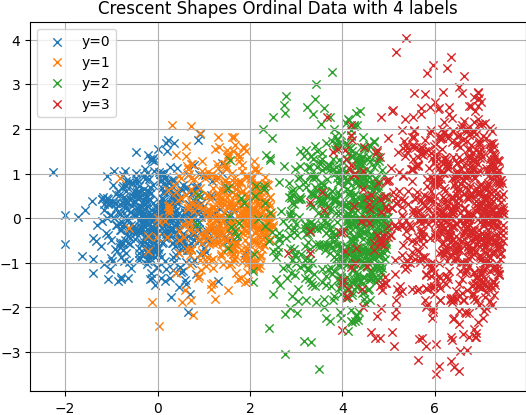

In [8]:
from IPython.display import Image
Image(filename='toydata/crescent_shapes_4_labels.png') 

# Ordinal Regression

## Without cutpoint training

In [23]:
# Set up the input and dense layer
input = tf.keras.Input(shape=(X_train.shape[-1],), name='Toy_Features')
dense_layer = tf.keras.layers.Dense(1, name='Latent_Linear')(input)

# Set static padding
cutpoints = tf.constant([0., 1., 2.])

# Set up CLM layer
ordinal_layer = tfp.layers.DistributionLambda(lambda t: CumulativeLink(loc=t, cutpoints=cutpoints), name='CLM_static_cutpoints')(dense_layer)
ordinal_model = tf.keras.Model(inputs=input, outputs=ordinal_layer, name='CLM-PC-HMM')

# Compile and fit model
ordinal_model.compile(optimizer=Adam(lr=0.01), loss=NegativeLogLikelihood())
history = ordinal_model.fit(X_train, y_train, epochs=100)

Epoch 1/100
63/63 [==============================] - 0s 2ms/step - loss: 0.7864
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6282
Epoch 3/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5955
Epoch 4/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5872
Epoch 5/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5844
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5839
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5834
Epoch 8/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5844
Epoch 9/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5833
Epoch 10/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5836
Epoch 11/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5833
Epoch 12/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5836
Epoch 13/100
63/63 [=================

<function matplotlib.pyplot.show(close=None, block=None)>

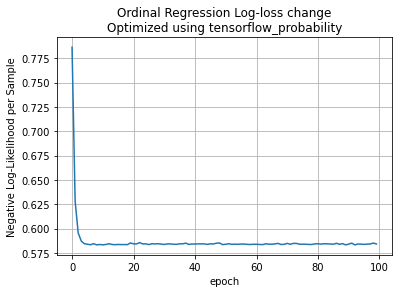

In [24]:
# Plot Training loss
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('Negative Log-Likelihood per Sample')
plt.title('Ordinal Regression Log-loss change\nOptimized using tensorflow_probability')
plt.grid()
plt.show

In [25]:
# Model Summary
tf.print(ordinal_model.summary())
print(ordinal_model.trainable_weights)

Model: "CLM-PC-HMM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Toy_Features (InputLayer)    [(None, 2)]               0         
_________________________________________________________________
Latent_Linear (Dense)        (None, 1)                 3         
_________________________________________________________________
CLM_static_cutpoints (Distri ((None, 1), (None, 1))    0         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None
[<tf.Variable 'Latent_Linear/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[0.75194454],
       [0.04154769]], dtype=float32)>, <tf.Variable 'Latent_Linear/bias:0' shape=(1,) dtype=float32, numpy=array([-1.0525283], dtype=float32)>]


In [26]:
# Predictions and probability scores for each dataset
y_train_pred = ordinal_model.predict(X_train)
y_test_pred = ordinal_model.predict(X_test)

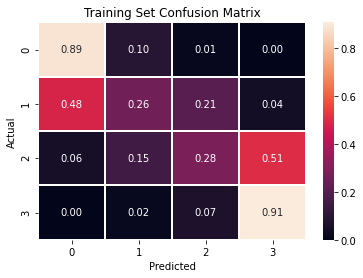

In [27]:
# Training Confusion Matrix
cf_matrix = confusion_matrix(y_train, y_train_pred, normalize='true', labels=list(range(n_classes)))

ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
ax.set_title(f'Training Set Confusion Matrix')
plt.show()

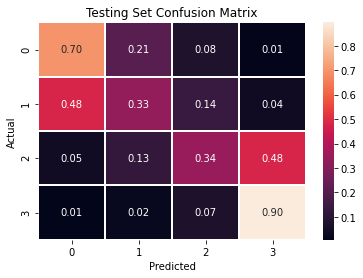

In [28]:
# Testing Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_test_pred, normalize='true',labels=list(range(n_classes)))

ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
ax.set_title(f'Testing Set Confusion Matrix')
plt.show()

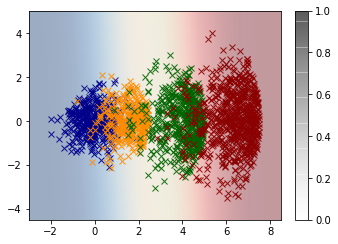

In [29]:
plot_model(ordinal_model, X_train, y_train)

## With cutpoints training

In [30]:
# Set up the input and dense layer
input = tf.keras.Input(shape=(X_train.shape[-1],), name='Toy_Features')
dense_layer = tf.keras.layers.Dense(1, name='Latent_Linear')(input)

# Set up cutpoints layer

random_values = tf.random.normal(shape=(n_classes - 2,), seed=random_state)
# random_values = tf.constant([0., 1., 2.])

padding_layer = tfp.layers.VariableLayer(shape=(n_classes - 2,),
                                        activation=tf.math.softplus,
                                        initializer=lambda shape, dtype: 
                                                tfp.util.TransformedVariable(
                                                    initial_value=random_values,
                                                    bijector=tfb.Scale(scale=1.),
                                                    dtype=dtype),
                                        # regularizer=tf.keras.regularizers.l2(),
                                        name='Padding_Variable'
                                        )(input)

ordinal_layer = tfp.layers.DistributionLambda(lambda t: CumulativeLink(loc=t[0], cutpoints=tf.cumsum(tf.concat([[0.], t[1]], axis=-1))), name='CLM')([dense_layer, padding_layer])
ordinal_model = tf.keras.Model(inputs=input, outputs=ordinal_layer, name='CLM-PC-HMM')

ordinal_model.compile(optimizer=Adam(lr=0.05), loss=NegativeLogLikelihood())
history = ordinal_model.fit(X_train, y_train, epochs=100)

Epoch 1/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5076
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: 0.3417
Epoch 3/100
63/63 [==============================] - 0s 2ms/step - loss: 0.3136
Epoch 4/100
63/63 [==============================] - 0s 2ms/step - loss: 0.3031
Epoch 5/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2993
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: 0.3015
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2952
Epoch 8/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2979
Epoch 9/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2966
Epoch 10/100
63/63 [==============================] - 0s 2ms/step - loss: 0.3029
Epoch 11/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2947
Epoch 12/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2941
Epoch 13/100
63/63 [=================

<function matplotlib.pyplot.show(close=None, block=None)>

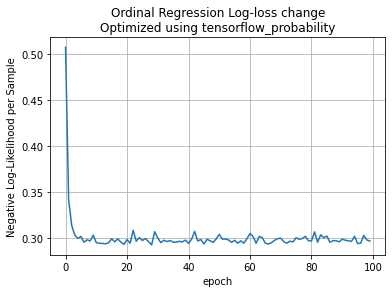

In [31]:
# Plot Training loss
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('Negative Log-Likelihood per Sample')
plt.title('Ordinal Regression Log-loss change\nOptimized using tensorflow_probability')
plt.grid()
plt.show

In [32]:
# Model Summary
tf.print(ordinal_model.summary())
print(ordinal_model.trainable_weights)

Model: "CLM-PC-HMM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Toy_Features (InputLayer)       [(None, 2)]          0                                            
__________________________________________________________________________________________________
Latent_Linear (Dense)           (None, 1)            3           Toy_Features[0][0]               
__________________________________________________________________________________________________
Padding_Variable (VariableLayer (2,)                 2           Toy_Features[0][0]               
__________________________________________________________________________________________________
CLM (DistributionLambda)        ((None, 1), (None, 1 0           Latent_Linear[0][0]              
                                                                 Padding_Variable[0][0]  

In [33]:
# Predictions and probability scores for each dataset
y_train_pred = ordinal_model.predict(X_train)
y_test_pred = ordinal_model.predict(X_test)

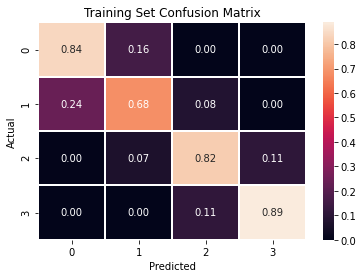

In [34]:
# Training Confusion Matrix
cf_matrix = confusion_matrix(y_train, y_train_pred, normalize='true', labels=list(range(n_classes)))

ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
ax.set_title(f'Training Set Confusion Matrix')
plt.show()

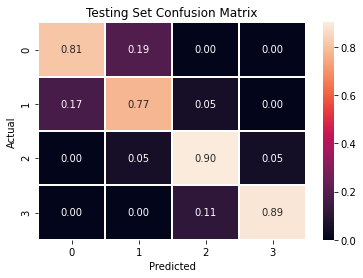

In [35]:
# Testing Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_test_pred, normalize='true',labels=list(range(n_classes)))

ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
ax.set_title(f'Testing Set Confusion Matrix')
plt.show()

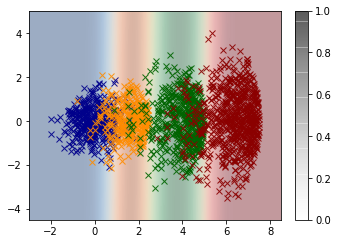

In [36]:
plot_model(ordinal_model, X_train, y_train)